 # Classificação de Sentimentos no Dataset "Restaurant Reviews" com o Modelo DistilBERT.

### Descrição do Dataset

Nesse trabalho, será analisado um dataset que contém reviews de restaurantes europeus. O dataset inclui informações como o o nome do restaurante, o país em que ele está localizado, o sentimento da avaliação (positivo ou negativo), o título da avaliação e o conteúdo da avaliação.

### Bibliotecas Necessárias

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch
import os
import re
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize ,sent_tokenize
nltk.download('punkt')
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


[nltk_data] Downloading package stopwords to /home/ester/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ester/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Carregamento do Dataset



In [113]:
df=pd.read_csv("European Restaurant Reviews.csv")

 Visualização do conteúdo e da estrutura do dataset

In [114]:
df.head()

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the c...
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium,..."
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,Nov 2023 •,"This is an attractive venue with welcoming, al..."
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Mar 2023 •,Sadly I used the high TripAdvisor rating too ...
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,Nov 2022 •,From the start this meal was bad- especially g...


Quantidade de observações, quantidade de dados ausentes e tipo de cada coluna

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country          1502 non-null   object
 1   Restaurant Name  1502 non-null   object
 2   Sentiment        1502 non-null   object
 3   Review Title     1502 non-null   object
 4   Review Date      1502 non-null   object
 5   Review           1502 non-null   object
dtypes: object(6)
memory usage: 70.5+ KB


Conclusão do carregamento

O Dataset possui 1502 observações com 6 colunas: Country (País), Restaurant Name (Nome do Restaurante), Review Title (Título da Avaliação), Review Date (Data da Avaliação), Review (Avaliação) e não possui nenhum dado ausente em nenhuma das 6 colunas, portanto, não será necessária nenhuma técnica de pré-processamento para lidar com dados ausentes. Todas as colunas são do tipo object (string).

### Informações do dataset

In [116]:
df.describe()

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review
count,1502,1502,1502,1502,1502,1502
unique,7,7,2,1343,143,1426
top,France,The Frog at Bercy Village,Positive,Excellent,May 2014 •,I actually never write reviews for the restaur...
freq,512,512,1237,9,108,4


O dataset contém dados de 7 restaurantes de 7 diferentes países.

Distribuição de sentimentos

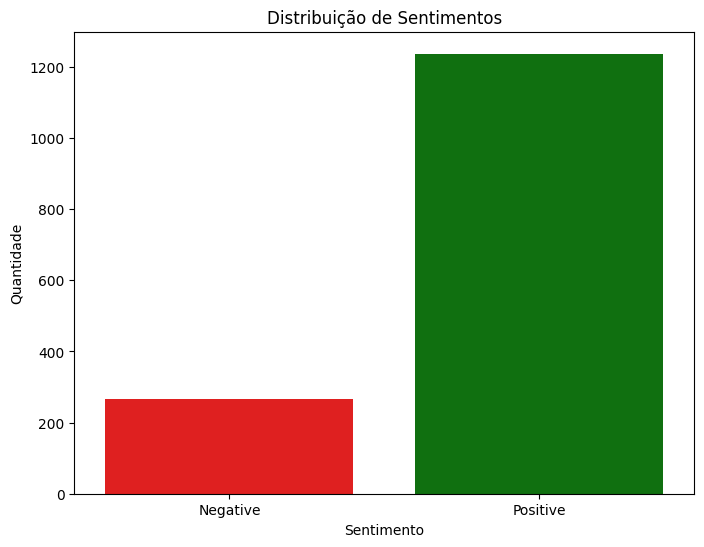

In [117]:
plt.figure(figsize=(8,6))
sns.countplot(x="Sentiment", data=df, hue="Sentiment" ,palette=['red', 'green'], legend=False) 
plt.title("Distribuição de Sentimentos")
plt.xlabel("Sentimento")
plt.ylabel("Quantidade")
plt.show()

Das 1502 observações, 1237 são positivas e 265 negativas.

Média de tamanho da avaliação de acordo com o sentimento

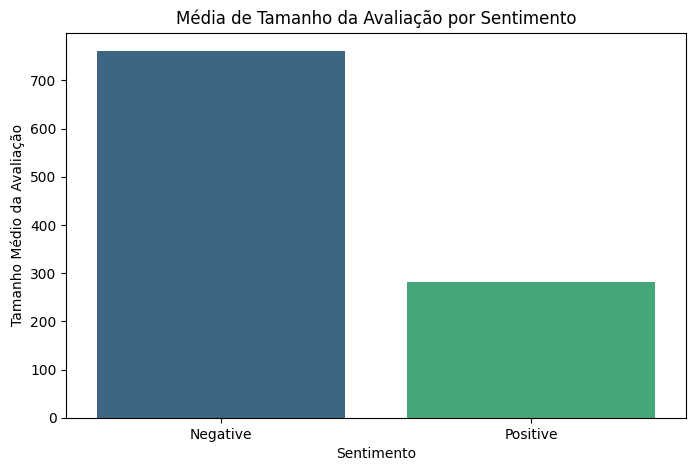

In [118]:
df['Review Length'] = df['Review'].apply(len)
avg_review_length = df.groupby('Sentiment')['Review Length'].mean()
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_review_length.index, y=avg_review_length.values, hue=avg_review_length.index,palette='viridis')
plt.title('Média de Tamanho da Avaliação por Sentimento')
plt.xlabel('Sentimento')
plt.ylabel('Tamanho Médio da Avaliação')
plt.show()

Esse gráfico mostra que as avaliações negativas tendem a ser muito mais longas do que as avaliações positivas (As positivas costumam ter cerca de 300 caracteres, enquanto as positivas costumam ter cerca de 700 caracteres). Isso evidencia que, quando os clientes estão insatisfeitos, eles costumam avaliar de forma mais detalhada em comparação a quando eles estão satisfeitos. Esse elemento pode ser utilizado pelo modelo de classificação de sentimentos para uma classificação mais precisa.

### Quantidade de avaliações separadas por país

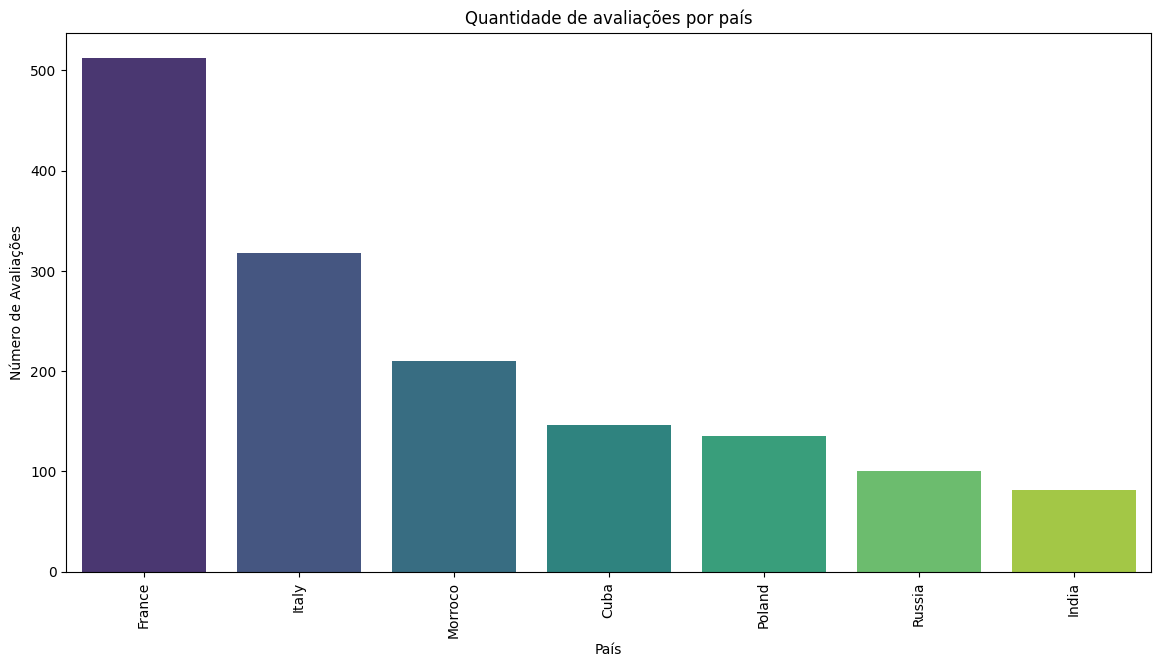

In [119]:
plt.figure(figsize=(14,7))
country_count=df["Country"].value_counts()
sns.barplot(x=country_count.index,y=country_count.values, hue=country_count.index, palette="viridis")
plt.title("Quantidade de avaliações por país")
plt.xlabel("País")
plt.ylabel("Número de Avaliações")
plt.xticks(rotation=90)
plt.show()

### Porcentagem de cada sentimento para cada país


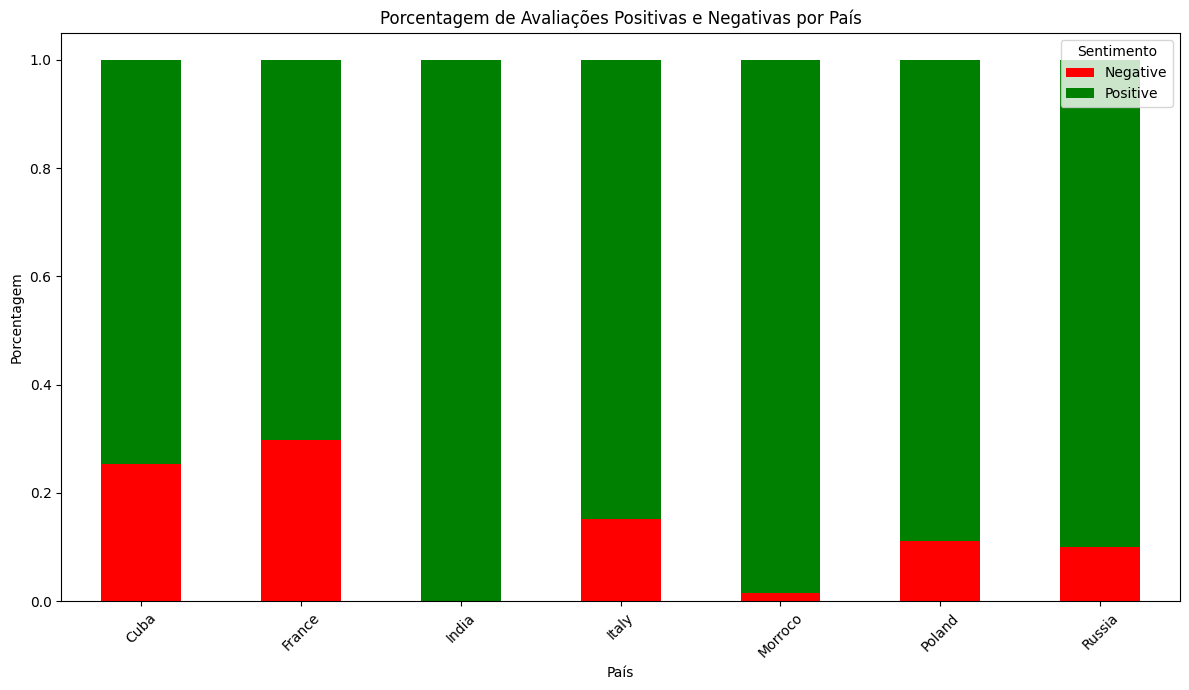

In [120]:
senti_country = df.groupby(['Country', 'Sentiment']).size().unstack(fill_value=0)

# Calcula a porcentagem de cada sentimento para cada país
senti_country_perc = senti_country.apply(lambda x: x / x.sum(), axis=1)

# Cria o gráfico de barras empilhadas
senti_country_perc.plot(kind='bar', stacked=True, figsize=(12, 7),
                        color=['red', 'green'])

# Configurações do gráfico
plt.title('Porcentagem de Avaliações Positivas e Negativas por País')
plt.xlabel('País')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45)
plt.legend(title='Sentimento')
plt.tight_layout()
plt.savefig('sentiment_by_country.png')
plt.show()

### Pré processamento de texto

In [121]:
# Para processamento de texto

def limparTexto(text):
    # Convert to lowercase
    text = text.lower()
    # Remove commas
    text = re.sub(r',', '', text)
    # Remove single quotation marks
    text = re.sub(r'\'', '', text)
    # Remove double quotation marks
    text = re.sub(r'\"', '', text)
    # Remove opening parentheses 
    text = re.sub(r'\(', '', text)
    # Remove closing parentheses   
    text = re.sub(r'\)', '', text)
    # Remove newline characters
    text = re.sub(r'\n', '', text)
    # Remove left double quotation marks  
    text = re.sub(r'“', '', text)
    # Remove right double quotation marks
    text = re.sub(r'”', '', text)
    # Remove right single quotation marks
    text = re.sub(r'’', '', text)
    # Remove periods
    text = re.sub(r'\.', '', text)
    # Remove semicolons
    text = re.sub(r';', '', text)
    # Remove colons 
    text = re.sub(r':', '', text)
    # Remove hyphens 
    text = re.sub(r'\-', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Return the cleaned text
    return text

In [122]:
# Aplica limparTexto na coluna 'Review'
df['cleaned_review'] = df['Review'].apply(limparTexto)
df['cleaned_review']

0       the manager became agressive when i said the c...
1       i ordered a beef fillet ask to be done medium ...
2       this is an attractive venue with welcoming alb...
3       sadly i  used the high tripadvisor rating too ...
4       from the start this meal was bad especially gi...
                              ...                        
1497    despite the other reviews saying that this is ...
1498    beer is good  food is awfull  the only decent ...
1499    for terrible service of a truly comedic level ...
1500    we visited the havanas club museum which is lo...
1501    food and service was awful very pretty stop go...
Name: cleaned_review, Length: 1502, dtype: object

In [123]:
# Remove stop words
def Remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = [word for word in text.split() if word.lower() not in stop_words]
    text = ' '.join(words)
    return text

# Aplicar o Remove_stop_words na coluna 'cleaned_review' 
df['cleaned_review'] = df['cleaned_review'].apply(Remove_stop_words)

df.head(5)

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review,Review Length,cleaned_review
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the c...,146,manager became agressive said carbonara good r...
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium,...",281,ordered beef fillet ask done medium got well d...
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,Nov 2023 •,"This is an attractive venue with welcoming, al...",260,attractive venue welcoming albeit somewhat slo...
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Mar 2023 •,Sadly I used the high TripAdvisor rating too ...,1513,sadly used high tripadvisor rating literally f...
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,Nov 2022 •,From the start this meal was bad- especially g...,1351,start meal bad especially given price visited ...


In [124]:
# Tokenizar todas as frases do cleaned_version 
df['cleaned_review_tokens'] = df['cleaned_review'].apply(lambda x: x.split())
texts = df['cleaned_review_tokens'].apply(lambda tokens: ' '.join(tokens)).tolist()
display(df)

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review,Review Length,cleaned_review,cleaned_review_tokens
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the c...,146,manager became agressive said carbonara good r...,"[manager, became, agressive, said, carbonara, ..."
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium,...",281,ordered beef fillet ask done medium got well d...,"[ordered, beef, fillet, ask, done, medium, got..."
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,Nov 2023 •,"This is an attractive venue with welcoming, al...",260,attractive venue welcoming albeit somewhat slo...,"[attractive, venue, welcoming, albeit, somewha..."
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Mar 2023 •,Sadly I used the high TripAdvisor rating too ...,1513,sadly used high tripadvisor rating literally f...,"[sadly, used, high, tripadvisor, rating, liter..."
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,Nov 2022 •,From the start this meal was bad- especially g...,1351,start meal bad especially given price visited ...,"[start, meal, bad, especially, given, price, v..."
...,...,...,...,...,...,...,...,...,...
1497,Cuba,Old Square (Plaza Vieja),Negative,The Tourism Trap,Oct 2016 •,Despite the other reviews saying that this is ...,776,despite reviews saying lovely place hang espec...,"[despite, reviews, saying, lovely, place, hang..."
1498,Cuba,Old Square (Plaza Vieja),Negative,the beer factory,Oct 2016 •,beer is good. food is awfull The only decent...,169,beer good food awfull decent thing shish kabob...,"[beer, good, food, awfull, decent, thing, shis..."
1499,Cuba,Old Square (Plaza Vieja),Negative,brewery,Oct 2016 •,"for terrible service of a truly comedic level,...",150,terrible service truly comedic level 23 full p...,"[terrible, service, truly, comedic, level, 23,..."
1500,Cuba,Old Square (Plaza Vieja),Negative,It's nothing exciting over there,Oct 2016 •,We visited the Havana's Club Museum which is l...,356,visited havanas club museum located old havana...,"[visited, havanas, club, museum, located, old,..."


Os países da parte central da Europa possuem uma quantidade maior de avaliações, evidenciando uma possível cultura culinária mais forte nesses países.

Nuvem de palavras mais utilizadas em avaliações positivas

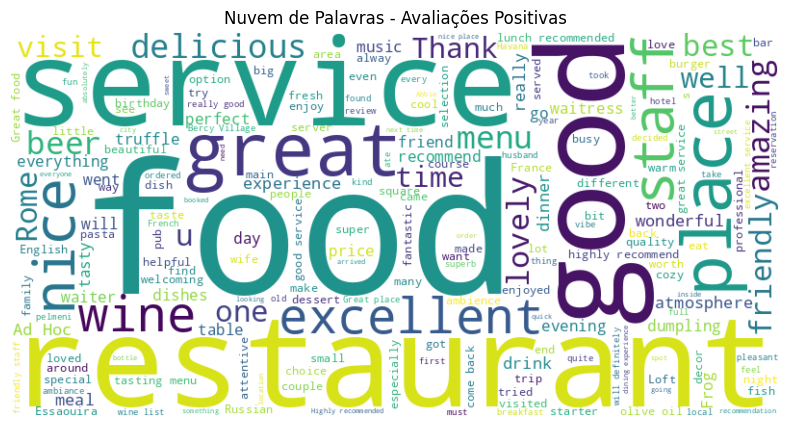

In [125]:
positive_reviews = df[df['Sentiment'] == 'Positive']['Review'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nuvem de Palavras - Avaliações Positivas')
plt.axis('off')
plt.show()

Nuvem de palavras mais utilizadas em avaliações negativas

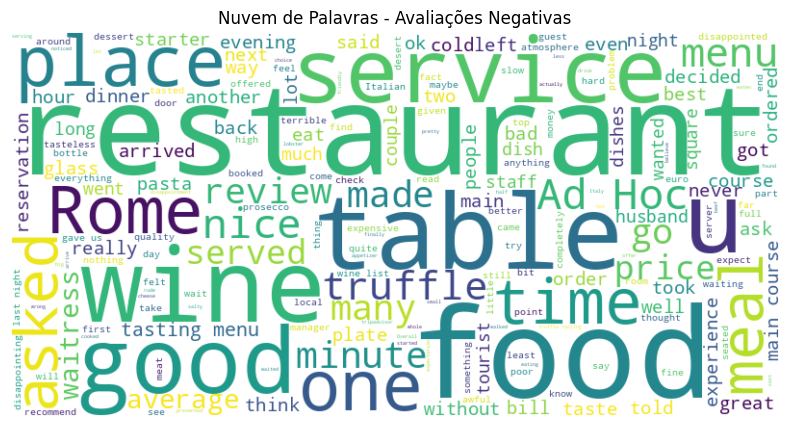

In [126]:
positive_reviews = df[df['Sentiment'] == 'Negative']['Review'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nuvem de Palavras - Avaliações Negativas')
plt.axis('off')
plt.show()

As palavras mais frequentes para cada tipo de sentimento são importantes informações para o modelo de linguagem classificar sentimentos com a maior acurácia possível. Porém, algumas palavras podem estar igualmente presentes em grande quantidade em ambos os sentimentos, como a palavra "restaurante", por exemplo.

### Média de sentimentos ao longo do tempo

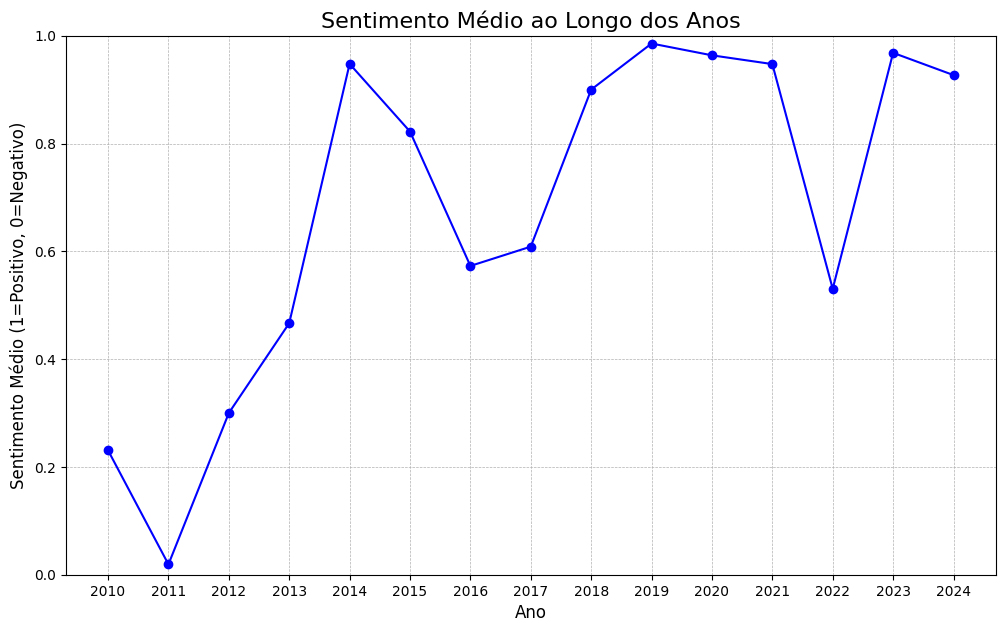

In [127]:
df_temp = df.copy()

# Extrair mês e ano (ex: "May 2024")
df_temp['Review Date'] = df_temp['Review Date'].str.extract(r'([A-Za-z]+\s+\d{4})')

# Corrigir abreviação não padrão "Sept"
df_temp['Review Date'] = df_temp['Review Date'].str.replace('Sept', 'Sep')

# Converter para datetime (dia 1 por padrão)
df_temp['Review Date'] = pd.to_datetime(df_temp['Review Date'], format='%b %Y', errors='coerce')

# Mapear sentimentos para valores numéricos
df_temp['Sentiment_Value'] = df_temp['Sentiment'].map({'Positive': 1, 'Negative': 0})

# Média de sentimento por ano
sentiment_by_year = df_temp.groupby(df_temp['Review Date'].dt.year)['Sentiment_Value'].mean()

# Plotar
plt.figure(figsize=(12, 7))
sentiment_by_year.plot(kind='line', marker='o', linestyle='-', color='b')

plt.title('Sentimento Médio ao Longo dos Anos', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Sentimento Médio (1=Positivo, 0=Negativo)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(sentiment_by_year.index)
plt.ylim(0, 1)
plt.show()


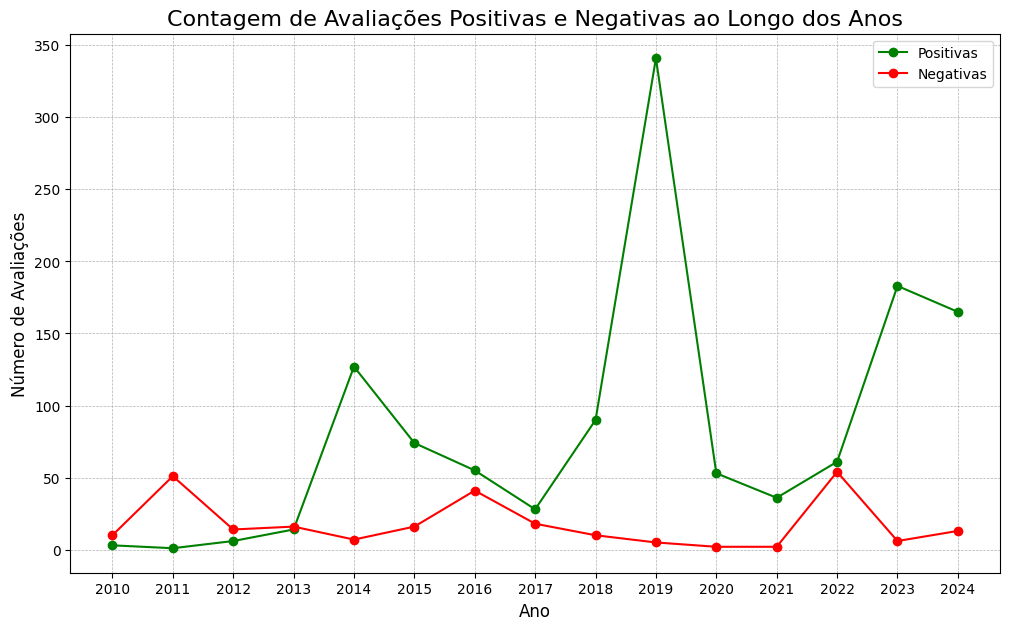

In [128]:
# 2. Extrair o ano para uma nova coluna
df_temp['Year'] = df_temp['Review Date'].dt.year

# 3. Agrupar por ano e sentimento e contar as ocorrências
# .size() conta o número de linhas para cada grupo (ano, sentimento)
# .unstack() pivota a coluna 'Sentiment' para que 'Positive' e 'Negative' virem colunas separadas
sentiment_counts_by_year = df_temp.groupby(['Year', 'Sentiment']).size().unstack(fill_value=0)


plt.figure(figsize=(12, 7))
plt.plot(sentiment_counts_by_year.index, sentiment_counts_by_year['Positive'], marker='o', linestyle='-', color='g', label='Positivas')
plt.plot(sentiment_counts_by_year.index, sentiment_counts_by_year['Negative'], marker='o', linestyle='-', color='r', label='Negativas')
plt.title('Contagem de Avaliações Positivas e Negativas ao Longo dos Anos', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Número de Avaliações', fontsize=12)
plt.xticks(sentiment_counts_by_year.index.astype(int)) # Garante que os anos sejam inteiros no eixo
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend() # Adiciona a legenda para identificar as linhas
plt.show()

## Aplicando o modelo Distilbert

In [129]:
texts = df['cleaned_review_tokens'].apply(lambda tokens: ' '.join(tokens)).tolist()

model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)

def predict_sentiment(texts):
    # Processa em batches para evitar uso excessivo de memória, aproveita melhor o hardware
    batch_size = 8 # Lotes de 8 textos
    sentiment_map = {0: "Muito Negativo", 1: "Negativo", 2: "Neutro", 3: "Positivo", 4: "Muito Positivo"}
    all_preds = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(probs, dim=-1).tolist()
        all_preds.extend([sentiment_map[p] for p in preds])
    return all_preds

resultados = predict_sentiment(texts)

for original, processed, sentiment in zip(df['Review'], texts, resultados):
    print(f"Texto original:\n{original}")
    print(f"Texto processado:\n{processed}")
    print(f"Sentimento: {sentiment}")
    print("-" * 80)


Texto original:
The manager became agressive when I said the carbonara was not good. She was rude. It was  a very bad experience. The worst in Rome in many years.
Texto processado:
manager became agressive said carbonara good rude bad experience worst rome many years
Sentimento: Muito Negativo
--------------------------------------------------------------------------------
Texto original:
I ordered a beef fillet ask to be done medium, I got it well done cooked and very dry, when I told them they took the steak and after 20 minutes they brought me another steak that was completely rare, I left all the steak , and they asked me about it but charged me the fool price.
Texto processado:
ordered beef fillet ask done medium got well done cooked dry told took steak 20 minutes brought another steak completely rare left steak asked charged fool price
Sentimento: Muito Negativo
--------------------------------------------------------------------------------
Texto original:
This is an attractive 

Acrescentando a coluna com os sentimentos atribuídos pelo Distilbert

In [130]:
df["sentiment_distilbert"] = resultados
df.to_csv("European_Restaurant_Reviews_with_Sentiment.csv", index=False)
display(df)

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review,Review Length,cleaned_review,cleaned_review_tokens,sentiment_distilbert
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the c...,146,manager became agressive said carbonara good r...,"[manager, became, agressive, said, carbonara, ...",Muito Negativo
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium,...",281,ordered beef fillet ask done medium got well d...,"[ordered, beef, fillet, ask, done, medium, got...",Muito Negativo
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,Nov 2023 •,"This is an attractive venue with welcoming, al...",260,attractive venue welcoming albeit somewhat slo...,"[attractive, venue, welcoming, albeit, somewha...",Neutro
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Mar 2023 •,Sadly I used the high TripAdvisor rating too ...,1513,sadly used high tripadvisor rating literally f...,"[sadly, used, high, tripadvisor, rating, liter...",Muito Positivo
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,Nov 2022 •,From the start this meal was bad- especially g...,1351,start meal bad especially given price visited ...,"[start, meal, bad, especially, given, price, v...",Negativo
...,...,...,...,...,...,...,...,...,...,...
1497,Cuba,Old Square (Plaza Vieja),Negative,The Tourism Trap,Oct 2016 •,Despite the other reviews saying that this is ...,776,despite reviews saying lovely place hang espec...,"[despite, reviews, saying, lovely, place, hang...",Neutro
1498,Cuba,Old Square (Plaza Vieja),Negative,the beer factory,Oct 2016 •,beer is good. food is awfull The only decent...,169,beer good food awfull decent thing shish kabob...,"[beer, good, food, awfull, decent, thing, shis...",Neutro
1499,Cuba,Old Square (Plaza Vieja),Negative,brewery,Oct 2016 •,"for terrible service of a truly comedic level,...",150,terrible service truly comedic level 23 full p...,"[terrible, service, truly, comedic, level, 23,...",Muito Negativo
1500,Cuba,Old Square (Plaza Vieja),Negative,It's nothing exciting over there,Oct 2016 •,We visited the Havana's Club Museum which is l...,356,visited havanas club museum located old havana...,"[visited, havanas, club, museum, located, old,...",Neutro


### Análise da Acurácia
Verificando os acertos do modelo

In [131]:
# Rótulos verdadeiros originais (ex: ['Positive', 'Negative', ...])
y_true_original = df['Sentiment'].tolist()

# Rótulos preditos, com 5 classes (ex: ['Positivo', 'Neutro', ...])
y_pred_original_5_classes = resultados

# Retirando o rótulo "Neutro"
mapa_simplificado = {
    "Muito Negativo": "Negative",
    "Negativo": "Negative",
    "Positivo": "Positive",
    "Muito Positivo": "Positive"
}

y_true_filtrado = []
y_pred_filtrado_e_simplificado = []

for verdadeiro, predito_5_classes in zip(y_true_original, y_pred_original_5_classes):    
    if predito_5_classes == "Neutro":
        continue
    y_true_filtrado.append(verdadeiro)
    y_pred_filtrado_e_simplificado.append(mapa_simplificado[predito_5_classes])


removidos = len(y_true_original) - len(y_true_filtrado)
print(f"Foram removidas {removidos} predições classificadas como 'Neutro'.")
print(f"Avaliando em um total de {len(y_true_filtrado)} amostras.")
print("-" * 50)

print("\nRelatório de Classificação (sem as predições 'Neutro'):")
print(classification_report(y_true_filtrado, y_pred_filtrado_e_simplificado))

Foram removidas 279 predições classificadas como 'Neutro'.
Avaliando em um total de 1223 amostras.
--------------------------------------------------

Relatório de Classificação (sem as predições 'Neutro'):
              precision    recall  f1-score   support

    Negative       0.95      0.86      0.90       169
    Positive       0.98      0.99      0.99      1054

    accuracy                           0.97      1223
   macro avg       0.96      0.93      0.94      1223
weighted avg       0.97      0.97      0.97      1223



Com uma acurácia geral de 97%, o modelo erra muito pouco. A cada 100 avaliações que o modelo analisou, ele acertou o sentimento de 97. 
Quando avalia uma classificação como negativa, acerta em 95% das vezes. Quando avalia como positiva, acerta em 98% das vezes.

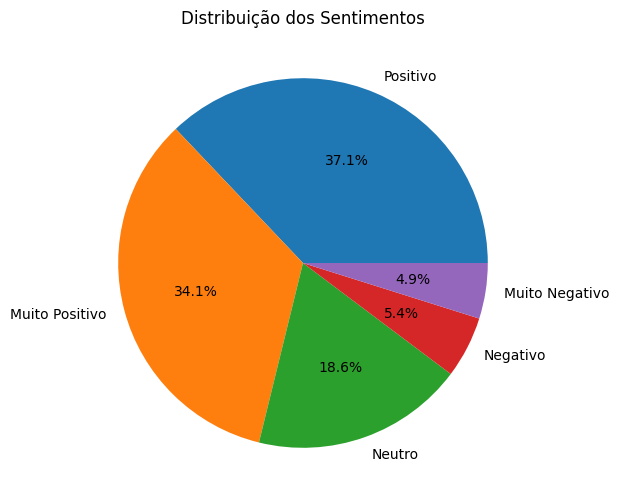

In [133]:
plt.figure(figsize=(10, 6))
plt.pie(df['sentiment_distilbert'].value_counts(), labels=df['sentiment_distilbert'].value_counts().index, autopct='%1.1f%%')
plt.title('Distribuição dos Sentimentos')
plt.show()

## Clusterização Semântica
O objetivo é agrupar as avaliações em temas, com base em seu significado contextual, capturado pelos embeddings do modelo Transformer.

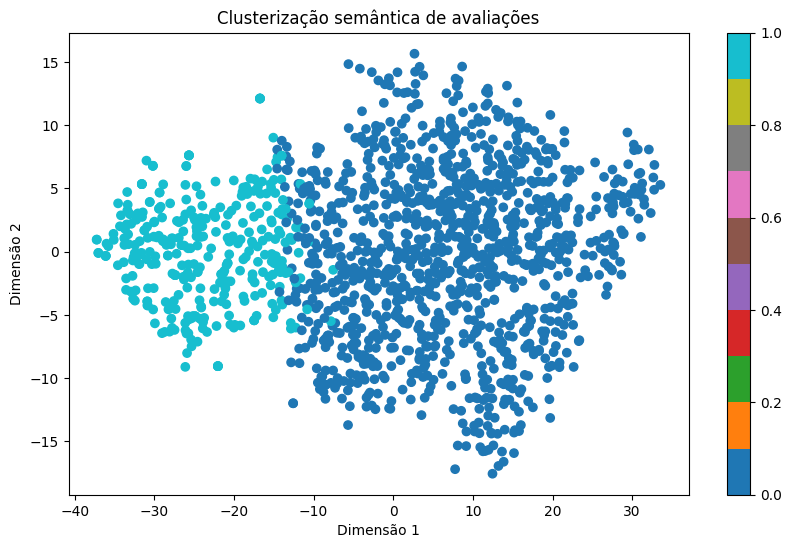

In [134]:
model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model2 = AutoModel.from_pretrained(model_name)

model2.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)

def get_embeddings(texts):
    embeddings = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
            outputs = model2(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  # [CLS] token
            embeddings.append(cls_embedding)
    return embeddings


df = pd.read_csv("European_Restaurant_Reviews_with_Sentiment.csv")
df['full_review'] = df['Review Title'].fillna('') + ' . ' + df['cleaned_review'].fillna('')
texts = df['full_review'].tolist()

embeddings = get_embeddings(texts)  # texts = lista de textos processados
embeddings = np.array(embeddings).astype(np.float64)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Adiciona ao dataframe
df['cluster'] = clusters

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=3, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='tab10')
plt.title("Clusterização semântica de avaliações")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.colorbar()
plt.show()

In [135]:
df['cluster'] = clusters
print(df['cleaned_review_tokens'].head())

0    ['manager', 'became', 'agressive', 'said', 'ca...
1    ['ordered', 'beef', 'fillet', 'ask', 'done', '...
2    ['attractive', 'venue', 'welcoming', 'albeit',...
3    ['sadly', 'used', 'high', 'tripadvisor', 'rati...
4    ['start', 'meal', 'bad', 'especially', 'given'...
Name: cleaned_review_tokens, dtype: object


Nessa etapa, encontramos as palavras que mais influenciam cada cluster. Elas ajudam a entender o "tema" de cada grupo de avaliações.

A vetorização TF-IDF mede a importância de uma palavra em uma avaliação específica, e em relação a todas as outras avaliações.

Além de algumas stopwords pré definidas, selecionamos algumas que, na nossa opinião, não influenciaram na seleção dos clusters.

In [136]:
minhas_stopwords_adicionais = ['great', 'didnt', 'service', 'like', 'good', 'place', 'nice', 'restaurant', 'food', 'rome']
stopwords_finais = list(ENGLISH_STOP_WORDS.union(minhas_stopwords_adicionais))


vectorizer = TfidfVectorizer(stop_words=stopwords_finais)
tfidf_matriz = vectorizer.fit_transform(texts)
feature_names = vectorizer.get_feature_names_out()

#Encontrando as palavras mais influentes de cada cluster
n_palavras = 10
for i in range(kmeans.n_clusters):
    print(f"--- Cluster {i} ---")

    #apenas avaliações do cluster i
    indice_cluster = df[df['cluster'] == i].index

    soma_scores = tfidf_matriz[indice_cluster].sum(axis=0)

    scores_array = np.asarray(soma_scores).flatten()
    #Selecionando as palavras com mas score
    top_indices = scores_array.argsort()[:-n_palavras-1:-1]

    top_words = [feature_names[idx] for idx in top_indices]
    print(', '.join(top_words))
    print()

--- Cluster 0 ---
excellent, amazing, delicious, friendly, best, staff, atmosphere, really, lovely, wine

--- Cluster 1 ---
wine, table, menu, meal, reservation, bad, terrible, asked, took, time



Analisando os resultados obtidos em cada cluster, observamos uma possível divisão entre avaliações positivas (cluster 0) e avaliações negativas (cluster 1)

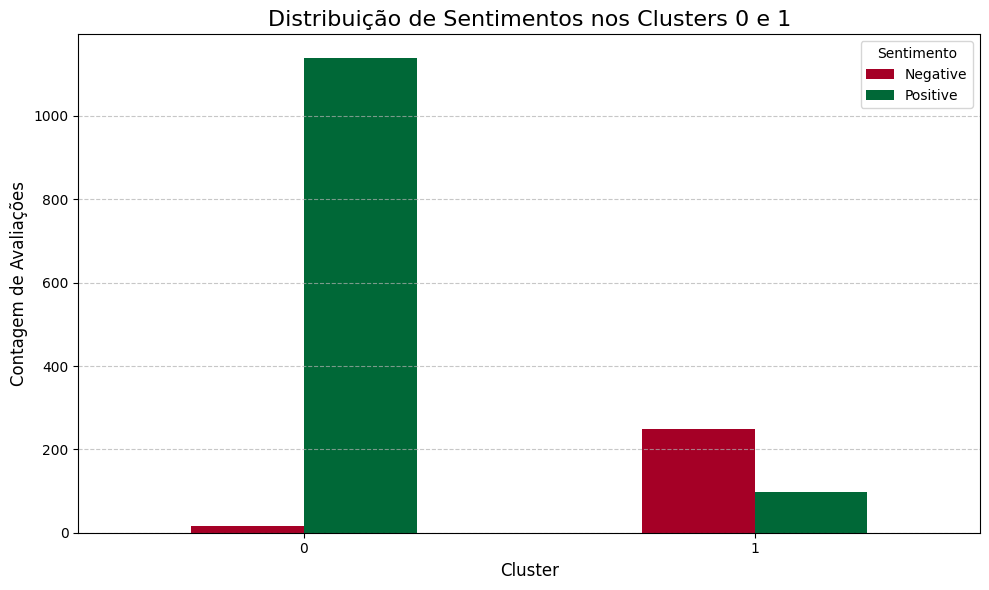

In [137]:
counts = df.groupby('cluster')['Sentiment'].value_counts()

plot_data = counts.unstack()
plot_data.plot(kind='bar', figsize=(10, 6), colormap='RdYlGn')

plt.title('Distribuição de Sentimentos nos Clusters 0 e 1', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Contagem de Avaliações', fontsize=12)
plt.xticks(rotation=0) # Mantém os rótulos do eixo x na horizontal
plt.legend(title='Sentimento')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Adiciona uma grade para melhor leitura
plt.tight_layout() # Ajusta o layout para evitar que os rótulos se sobreponham

plt.show()

Essa divisão ficou bem nítida, principalmente no cluster 0, no qual pouquísimas avaliações foram calssificadas como negativas.

## Testando o modelo para novas avaliações

In [138]:
novas_avaliacoes = [
    "Serviço espetacular e a comida estava simplesmente perfeita. Uma noite memorável!",
    "O melhor bacalhau que já comi em Lisboa. Ambiente acolhedor e preço justo.",
    "Adorei a decoração e a música ambiente. Um lugar com uma vibe ótima para ir com amigos.",
    "Esperamos mais de uma hora pela comida, que ainda por cima chegou fria. Decepcionante.",
    "O garçom foi extremamente rude e parecia com pressa para nos expulsar. Nunca mais ponho os pés aqui.",
    "Comida sem sabor e absurdamente cara pelo que oferece. Não vale a pena.",
    "A localização é excelente e o prato principal estava bom, mas a sobremesa parecia velha e o café estava horrível.",
    "Gostei da comida, mas o barulho era tanto que mal conseguia conversar com a pessoa à minha frente.",
    "O cardápio tem opções vegetarianas e o restaurante abre para almoço aos domingos.",
    "Sem dúvida, uma das melhores experiências gastronômicas que já tive. Cada detalhe foi pensado. Fantástico!",
    "The atmosphere was magical, with a beautiful view of the city. Highly recommended for a special occasion.",
    "From start to finish, the service was attentive without being intrusive. The steak was cooked to perfection.",
    "A hidden gem! The prices are very reasonable for the quality of food you get. We will be back.",
    "The place was dirty, our table was sticky and there were flies everywhere. We left before ordering.",
    "I ordered the seafood pasta and it was completely tasteless, just a watery sauce. A huge letdown.",
    "They got our order wrong twice and didn't even apologize. The staff seemed completely overwhelmed and disorganized.",
    "The pizza itself was decent, but they charge extra for every single topping, making it surprisingly expensive.",
    "Great location and a very cool interior design, but the cocktails were weak and overpriced.",
    "The restaurant has free Wi-Fi and accepts all major credit card payments.",
    "Every dish was a work of art, both visually and in terms of flavor. An absolute must-visit for any foodie."
]

previsoes_sentimento = predict_sentiment(novas_avaliacoes)

embeddings_novos = get_embeddings(novas_avaliacoes)
previsoes_cluster = kmeans.predict(embeddings_novos)

print("\n--- Análise Combinada: Sentimento e Cluster ---")
for i, (avaliacao, sentimento, cluster) in enumerate(zip(novas_avaliacoes, previsoes_sentimento, previsoes_cluster), 1):
    print(f"--- Avaliação {i} ---")
    print(f"Texto   : {avaliacao}")
    print(f"Sentimento: {sentimento}")
    print(f"Cluster   : {cluster}\n")


--- Análise Combinada: Sentimento e Cluster ---
--- Avaliação 1 ---
Texto   : Serviço espetacular e a comida estava simplesmente perfeita. Uma noite memorável!
Sentimento: Muito Positivo
Cluster   : 0

--- Avaliação 2 ---
Texto   : O melhor bacalhau que já comi em Lisboa. Ambiente acolhedor e preço justo.
Sentimento: Muito Positivo
Cluster   : 0

--- Avaliação 3 ---
Texto   : Adorei a decoração e a música ambiente. Um lugar com uma vibe ótima para ir com amigos.
Sentimento: Positivo
Cluster   : 0

--- Avaliação 4 ---
Texto   : Esperamos mais de uma hora pela comida, que ainda por cima chegou fria. Decepcionante.
Sentimento: Positivo
Cluster   : 1

--- Avaliação 5 ---
Texto   : O garçom foi extremamente rude e parecia com pressa para nos expulsar. Nunca mais ponho os pés aqui.
Sentimento: Muito Negativo
Cluster   : 1

--- Avaliação 6 ---
Texto   : Comida sem sabor e absurdamente cara pelo que oferece. Não vale a pena.
Sentimento: Muito Negativo
Cluster   : 1

--- Avaliação 7 ---
Texto 